In [1]:
import os
import re
import configparser

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


from source.processes import Shuffler
from source.datamodels.datamodels import BootstrapDatasetsComparisonResults
from source.datamodels import iterators
from source.preprocessing import splitter
from source.utils import get_project_root

In [2]:
root = get_project_root()
config = configparser.ConfigParser()
config.read(os.path.join(root, "userconfig.ini"))

own_data_path = config['Path']['own_data_path']
third_party_data_path = config['Path']['third_party_data_path']
Cesar1_path = config['Path']['Cesar1_path']

images_path = config['Path']['images_path']
public_images_path = config['Path']['public_images_path']

tables_path = config['Path']['tables_path']
public_tables_path = config['Path']['public_tables_path']

bootstrap_jsons_path = config['Path']['bootstrap_jsons_path']
single_jsons_path = config['Path']['single_jsons_path']

# 1 Load datasets

## 1.1 Load raw datasets
Load datasets that require to be splitted on chunks

In [3]:
full_dataset_our = pd.read_csv(os.path.join(root, own_data_path, 'bearings.csv'), index_col=0)
full_dataset_our.head()

C:\Users\Ruslan\AppData\Roaming\Python\Python38\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,target,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,hz,w
0,0,1,0,1,0.000000,0.113269,0.149706,-0.110275,-0.186030,0.194450,0.454299,0.0,0.0,0.000006
1,0,1,0,1,0.000333,-0.367713,-0.228832,0.177821,0.285992,0.002226,-0.043930,0.0,0.0,0.000243
2,0,1,0,1,0.000667,0.113269,0.149706,-0.398371,-0.091625,0.002226,0.454299,0.0,0.0,0.000369
3,0,1,0,1,0.001000,-0.175320,-0.228832,-0.110275,0.285992,0.002226,0.255007,0.0,0.0,0.000520
4,0,1,0,1,0.001333,-0.079124,0.055072,-0.110275,0.191588,0.002226,0.255007,0.0,0.0,0.000175


In [5]:
full_dataset_cesar = pd.read_csv(os.path.join(root, third_party_data_path, 'N1 Cesar Ricardo/csv/bearings.csv'))
full_dataset_cesar.head()

,target,a1_y,a2_y,rpm,experiment_id,timestamp
0,1,1.937934,1.954861,200,1,0.000000
1,1,1.937547,1.954629,200,1,0.000025
2,1,1.937166,1.954989,200,1,0.000050
3,1,1.937594,1.955540,200,1,0.000075
4,1,1.938502,1.955792,200,1,0.000100


In [15]:
%%time

stats = iterators.Stats.get_keys()
splitter_processor = splitter.Splitter(use_signal=True, use_specter=True, specter_threshold=500, stats=stats, scaler=StandardScaler)
prepared_data_our = splitter_processor.split_dataset(full_dataset_our, stable_area=[(10, 19)], splits_number=10, signal_data_columns=['a1_y', 'a2_y'])
print(f"features number: {prepared_data_our.shape[1]-2}")
print(f"examples number: {prepared_data_our.shape[0]}")

prepared_data_our.to_csv(os.path.join(root, own_data_path, 'processed_full_signal_specter500_Zscale.csv'), index=None)
prepared_data_our.head()

F:\Anaconda\lib\site-packages\scipy\stats\stats.py:1021: RuntimeWarning: divide by zero encountered in true_divide
  return a.std(axis, ddof=ddof) / a.mean(axis)
F:\Anaconda\lib\site-packages\scipy\stats\stats.py:1021: RuntimeWarning: divide by zero encountered in true_divide
  return a.std(axis, ddof=ddof) / a.mean(axis)


features number: 68
examples number: 1120
Wall time: 5min 34s


,target,group,a1_y_signal_kurtosis,a1_y_signal_std,a1_y_signal_sample_entropy,a1_y_signal_energy,a1_y_signal_iqr,a1_y_signal_hurst,a1_y_signal_higuchi_fd,a1_y_signal_complexity,...,a2_y_specter_complexity,a2_y_specter_mean,a2_y_specter_zero_crossing,a2_y_specter_shannon_entropy,a2_y_specter_activity,a2_y_specter_skew,a2_y_specter_variation,a2_y_specter_crest_factor,a2_y_specter_range,a2_y_specter_petrosian_fd
0,0.0,1.0,0.389080,1.0,2.672277,2700.0,1.338704,0.226155,1.494302,3.100466,...,1.424371,2.975640,0.0,8.810572,1.206551,11.929799,7.257098,15.630495,340.722299,1.039601
1,0.0,1.0,-0.164861,1.0,2.657879,2700.0,1.417060,0.266961,1.552042,2.866693,...,1.523741,2.971037,0.0,8.810572,1.013906,11.079897,6.522717,14.284588,280.058663,1.039601
2,0.0,1.0,-0.257201,1.0,2.736736,2700.0,1.400202,0.216258,1.544652,2.939681,...,1.406007,2.977051,0.0,8.810572,1.130858,16.044168,9.544981,18.805724,537.306291,1.039351
3,0.0,1.0,-0.178955,1.0,2.671205,2700.0,1.459331,0.205719,1.516847,3.121533,...,1.338816,2.977066,0.0,8.810572,1.243058,19.140523,11.617536,20.414837,708.682034,1.038474
4,0.0,1.0,-0.427914,1.0,2.742263,2700.0,1.476226,0.243431,1.538823,2.935835,...,1.468418,2.974270,0.0,8.810572,1.060101,16.448731,9.439389,19.093236,539.047729,1.038223


In [16]:
%%time

stats = iterators.Stats.get_keys()
splitter_processor = splitter.Splitter(use_signal=True, use_specter=True, specter_threshold=500, stats=stats, scaler=StandardScaler)
prepared_data_cesar = splitter_processor.split_dataset(full_dataset_cesar, stable_area=[(0.1, 3.)], splits_number=10,
                                                     signal_data_columns=['a1_y', 'a2_y'])
prepared_data_cesar.to_csv(os.path.join(root, third_party_data_path, 'N1 Cesar Ricardo/csv/processed_full_signal_specter500_Zscale.csv'), index=None)
print(f"features number: {prepared_data_cesar.shape[1]-2}")
print(f"examples number: {prepared_data_cesar.shape[0]}")
prepared_data_cesar.head()

features number: 68
examples number: 450
Wall time: 1h 42min


,target,group,a1_y_signal_kurtosis,a1_y_signal_std,a1_y_signal_sample_entropy,a1_y_signal_energy,a1_y_signal_iqr,a1_y_signal_hurst,a1_y_signal_higuchi_fd,a1_y_signal_complexity,...,a2_y_specter_complexity,a2_y_specter_mean,a2_y_specter_zero_crossing,a2_y_specter_shannon_entropy,a2_y_specter_activity,a2_y_specter_skew,a2_y_specter_variation,a2_y_specter_crest_factor,a2_y_specter_range,a2_y_specter_petrosian_fd
0,1.0,1.0,-1.299056,1.0,2.588354,11600.0,1.894774,0.509540,1.571290,19.811359,...,1.158244,39.364422,0.0,7.179909,1.330692,11.569129,9.184309,11.914002,4332.785709,1.051952
1,1.0,1.0,5.031827,1.0,2.741200,11600.0,1.141188,0.679132,1.626868,3.096761,...,1.127153,26.006183,0.0,7.179909,1.385901,9.987184,2.778912,10.959519,841.753348,1.045664
2,1.0,1.0,1.000415,1.0,2.850815,11600.0,1.304361,0.584649,1.605020,3.387253,...,1.220686,21.155175,0.0,7.179909,1.393969,4.517764,1.583176,6.504259,257.660646,1.049546
3,1.0,1.0,55.793540,1.0,2.572309,11600.0,0.940736,0.589096,1.684588,1.833701,...,1.592176,26.755993,0.0,7.179909,0.991321,4.396344,1.687958,6.937298,364.163844,1.050028
4,1.0,1.0,0.817378,1.0,2.843848,11600.0,1.284741,0.485474,1.620770,3.012283,...,1.364538,20.366866,0.0,7.179909,1.245271,2.706957,1.147172,5.337646,165.441178,1.050510


V2

## 1.2 Load prepared datasets
load datasets tat were already prepared for training

In [3]:
prepared_data_our = pd.read_csv(os.path.join(root, own_data_path, 'processed_full_signal_specter500_Zscale.csv'), delimiter=',')  # our experiment
prepared_data_cesar = pd.read_csv(os.path.join(root, third_party_data_path, 'N1 Cesar Ricardo', 'csv',
                                               'processed_full_signal_specter500_Zscale.csv'), delimiter=',')  # third-party dataset
prepared_data_cesar.head()

,target,group,a1_y_signal_kurtosis,a1_y_signal_std,a1_y_signal_sample_entropy,a1_y_signal_energy,a1_y_signal_iqr,a1_y_signal_hurst,a1_y_signal_higuchi_fd,a1_y_signal_complexity,...,a2_y_specter_complexity,a2_y_specter_mean,a2_y_specter_zero_crossing,a2_y_specter_shannon_entropy,a2_y_specter_activity,a2_y_specter_skew,a2_y_specter_variation,a2_y_specter_crest_factor,a2_y_specter_range,a2_y_specter_petrosian_fd
0,1.0,1.0,-1.299056,1.0,2.588354,11600.0,1.894774,0.509540,1.571290,19.811359,...,1.158244,39.364422,0.0,7.179909,1.330692,11.569129,9.184309,11.914002,4332.785709,1.051952
1,1.0,1.0,5.031827,1.0,2.741200,11600.0,1.141188,0.679132,1.626868,3.096761,...,1.127153,26.006183,0.0,7.179909,1.385901,9.987184,2.778912,10.959519,841.753348,1.045664
2,1.0,1.0,1.000415,1.0,2.850815,11600.0,1.304361,0.584649,1.605020,3.387253,...,1.220686,21.155175,0.0,7.179909,1.393969,4.517764,1.583176,6.504259,257.660646,1.049546
3,1.0,1.0,55.793540,1.0,2.572309,11600.0,0.940736,0.589096,1.684588,1.833701,...,1.592176,26.755993,0.0,7.179909,0.991321,4.396344,1.687958,6.937298,364.163844,1.050028
4,1.0,1.0,0.817378,1.0,2.843848,11600.0,1.284741,0.485474,1.620770,3.012283,...,1.364538,20.366866,0.0,7.179909,1.245271,2.706957,1.147172,5.337646,165.441178,1.050510


# 2 Concatenate Dataframes

In [4]:
our_dataset_cols = prepared_data_our.columns
cols_to_leave = [col for col in our_dataset_cols if not re.search(pattern='^a[12]_[xz]', string=col)]
prepared_data_our = prepared_data_our[cols_to_leave]
prepared_data_our.head()

,target,group,a1_y_signal_kurtosis,a1_y_signal_std,a1_y_signal_sample_entropy,a1_y_signal_energy,a1_y_signal_iqr,a1_y_signal_hurst,a1_y_signal_higuchi_fd,a1_y_signal_complexity,...,a2_y_specter_complexity,a2_y_specter_mean,a2_y_specter_zero_crossing,a2_y_specter_shannon_entropy,a2_y_specter_activity,a2_y_specter_skew,a2_y_specter_variation,a2_y_specter_crest_factor,a2_y_specter_range,a2_y_specter_petrosian_fd
0,0.0,1.0,0.389080,1.0,2.672277,2700.0,1.338704,0.226155,1.494302,3.100466,...,1.424371,2.975640,0.0,8.810572,1.206551,11.929799,7.257098,15.630495,340.722299,1.039601
1,0.0,1.0,-0.164861,1.0,2.657879,2700.0,1.417060,0.266961,1.552042,2.866693,...,1.523741,2.971037,0.0,8.810572,1.013906,11.079897,6.522717,14.284588,280.058663,1.039601
2,0.0,1.0,-0.257201,1.0,2.736736,2700.0,1.400202,0.216258,1.544652,2.939681,...,1.406007,2.977051,0.0,8.810572,1.130858,16.044168,9.544981,18.805724,537.306291,1.039351
3,0.0,1.0,-0.178955,1.0,2.671205,2700.0,1.459331,0.205719,1.516847,3.121533,...,1.338816,2.977066,0.0,8.810572,1.243058,19.140523,11.617536,20.414837,708.682034,1.038474
4,0.0,1.0,-0.427914,1.0,2.742263,2700.0,1.476226,0.243431,1.538823,2.935835,...,1.468418,2.974270,0.0,8.810572,1.060101,16.448731,9.439389,19.093236,539.047729,1.038223


In [5]:
our_groups_max = np.max(prepared_data_our['group'])
prepared_data_cesar['group'] = prepared_data_cesar['group'].apply(lambda x: x + our_groups_max)

In [6]:
prepared_data = pd.concat([prepared_data_our, prepared_data_cesar])
prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1570 entries, 0 to 449
Data columns (total 70 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   target                        1570 non-null   float64
 1   group                         1570 non-null   float64
 2   a1_y_signal_kurtosis          1570 non-null   float64
 3   a1_y_signal_std               1570 non-null   float64
 4   a1_y_signal_sample_entropy    1570 non-null   float64
 5   a1_y_signal_energy            1570 non-null   float64
 6   a1_y_signal_iqr               1570 non-null   float64
 7   a1_y_signal_hurst             1570 non-null   float64
 8   a1_y_signal_higuchi_fd        1570 non-null   float64
 9   a1_y_signal_complexity        1570 non-null   float64
 10  a1_y_signal_mean              1570 non-null   float64
 11  a1_y_signal_zero_crossing     1570 non-null   float64
 12  a1_y_signal_shannon_entropy   1570 non-null   float64
 13  a1_y

# 3 Run GridSearch

In [30]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [31]:
dataset_cols = prepared_data.columns
cols_to_leave = [col for col in dataset_cols if not re.search(pattern='_mean$|_std$|_variation$', string=col)]
prepared_data = prepared_data[cols_to_leave]
prepared_data.head()

,target,group,a1_y_signal_kurtosis,a1_y_signal_sample_entropy,a1_y_signal_energy,a1_y_signal_iqr,a1_y_signal_hurst,a1_y_signal_higuchi_fd,a1_y_signal_complexity,a1_y_signal_zero_crossing,...,a2_y_specter_hurst,a2_y_specter_higuchi_fd,a2_y_specter_complexity,a2_y_specter_zero_crossing,a2_y_specter_shannon_entropy,a2_y_specter_activity,a2_y_specter_skew,a2_y_specter_crest_factor,a2_y_specter_range,a2_y_specter_petrosian_fd
0,0.0,1.0,0.389080,2.672277,2700.0,1.338704,0.226155,1.494302,3.100466,378.0,...,0.512995,1.811762,1.424371,0.0,8.810572,1.206551,11.929799,15.630495,340.722299,1.039601
1,0.0,1.0,-0.164861,2.657879,2700.0,1.417060,0.266961,1.552042,2.866693,382.0,...,0.530134,1.775582,1.523741,0.0,8.810572,1.013906,11.079897,14.284588,280.058663,1.039601
2,0.0,1.0,-0.257201,2.736736,2700.0,1.400202,0.216258,1.544652,2.939681,375.0,...,0.411808,1.841535,1.406007,0.0,8.810572,1.130858,16.044168,18.805724,537.306291,1.039351
3,0.0,1.0,-0.178955,2.671205,2700.0,1.459331,0.205719,1.516847,3.121533,398.0,...,0.360975,1.885853,1.338816,0.0,8.810572,1.243058,19.140523,20.414837,708.682034,1.038474
4,0.0,1.0,-0.427914,2.742263,2700.0,1.476226,0.243431,1.538823,2.935835,397.0,...,0.453817,1.831159,1.468418,0.0,8.810572,1.060101,16.448731,19.093236,539.047729,1.038223


In [32]:
LR_estimator = LogisticRegression(max_iter=50000)
SVC_estimator = SVC(max_iter=50000)
RFC_estimator = RandomForestClassifier()
GBM_estimator = GradientBoostingClassifier()
KNN_estimator = KNeighborsClassifier()

In [33]:
LR_grid = {"C": list(np.logspace(-3, 6, 10))}  # np.ndarrays are not serializable
SVC_grid = {"C": list(np.logspace(-3, 6, 10)), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
RFC_grid = {'n_estimators': [20, 50, 100, 200, 500], 'max_depth': [1, 3, 5, 9, 15, 30, None]}
GBM_grid = {'learning_rate': list(np.logspace(-2, 1, 4)), 'n_estimators': [50, 100, 200, 500], 'max_depth': [1, 3, 5, 9, 15, 30, None]}
KNN_grid = {'n_neighbors': [1, 3, 5, 7, 9, 15, 35], 'p': [1, 1.5, 2, 2.5, 6, 100]}

In [34]:
X = prepared_data.drop(columns=['target', 'group']).values
y = prepared_data['target'].values
groups = prepared_data['group'].values
our_groups = prepared_data_our['group'].values
cesar_groups = prepared_data_cesar['group'].values

X_scaled = StandardScaler().fit_transform(X)

In [38]:
stats = iterators.Stats.get_keys()
stats = [stat for stat in stats if stat not in['mean', 'std', 'variation']]
print(stats)

['kurtosis', 'skew', 'range', 'iqr', 'sample_entropy', 'shannon_entropy', 'energy', 'hurst', 'petrosian_fd', 'zero_crossing', 'higuchi_fd', 'activity', 'complexity', 'crest_factor']


In [39]:
from datetime import datetime

GS_results_objects = []
estimators = [LR_estimator, SVC_estimator, RFC_estimator, KNN_estimator]
grids = [LR_grid, SVC_grid, RFC_grid, KNN_grid]
names = ['LR', 'SVC', 'RFC', 'KNN']
score_name = 'f1'
n_repeats = 100

for estimator, grid, name in zip(estimators, grids, names):
    start_time = datetime.now()
    cv = Shuffler.PresplitedOverlapGroupCV(subset_size=0.63, n_repeats=n_repeats).split(X_scaled, y, groups=groups, train_groups=our_groups, test_groups=cesar_groups)
    GSCV = GridSearchCV(estimator, grid, scoring=score_name, cv=cv)
    GSCV.fit(X_scaled, y, groups=groups)

    print(f"Best {score_name} score for {name}: {100*GSCV.best_score_:.3f}% \n best params: {GSCV.best_params_}\n required time: {datetime.now() - start_time}\n")

    highest_score_params = GSCV.cv_results_['rank_test_score'][0]
    split_scores_names = [f'split{idx}_test_score' for idx in range(n_repeats)]

    scores_distr = []
    for split_scores_name in split_scores_names:
        scores_distr.append(GSCV.cv_results_[split_scores_name][highest_score_params-1])
    res = BootstrapDatasetsComparisonResults(
        run_label = "GS",
        model_name = name,
        hyperparameters = GSCV.best_params_,
        use_signal = True,
        use_specter = True,
        specter_threshold = 500,
        axes = ['a1_y', 'a2_y'],
        stats = stats,
        scores = {score_name: GSCV.best_score_},
        predictions = None,
        resampling_number = n_repeats,
        bootstrap_scores =  {score_name: scores_distr},
        train_brg_id = list(our_groups),
        test_brg_id = list(cesar_groups),
        train_dataset_name = 'our',
        test_dataset_name = 'Cesar1',
        signal_scaler = "Standard",
    )
    GS_results_objects.append(res)

Best f1 score for LR: 30.506% 
 best params: {'C': 1000000.0}
 required time: 0:17:13.076951



F:\Anaconda\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
F:\Anaconda\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
F:\Anaconda\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
F:\Anaconda\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
F:\Anaconda\

Best f1 score for SVC: 27.778% 
 best params: {'C': 10000.0, 'kernel': 'linear'}
 required time: 0:03:20.239503

Best f1 score for RFC: 1.578% 
 best params: {'max_depth': 9, 'n_estimators': 20}
 required time: 0:30:39.639272

Best f1 score for KNN: 9.174% 
 best params: {'n_neighbors': 15, 'p': 6}
 required time: 0:44:12.193847



In [44]:
from source.postprocessing.mljson import serialize_results


serialize_results(GS_results_objects, filenames=[f"{model}_DSM_C1_GS_1_11_2021.json" for model in names], filepath=os.path.join(root, bootstrap_jsons_path, 'DatasetsCompare'))

In [45]:
from datetime import datetime

GS_results_objects_ = []
estimators = [LR_estimator, SVC_estimator, RFC_estimator, KNN_estimator]
grids = [LR_grid, SVC_grid, RFC_grid, KNN_grid]
names = ['LR', 'SVC', 'RFC', 'KNN']
score_name = 'f1'
n_repeats = 100

for estimator, grid, name in zip(estimators, grids, names):
    start_time = datetime.now()
    cv = Shuffler.PresplitedOverlapGroupCV(subset_size=0.63, n_repeats=n_repeats).split(X_scaled, y, groups=groups, train_groups=cesar_groups, test_groups=our_groups)
    GSCV = GridSearchCV(estimator, grid, scoring=score_name, cv=cv)
    GSCV.fit(X_scaled, y, groups=groups)

    print(f"Best {score_name} score for {name}: {100*GSCV.best_score_:.3f}% \n best params: {GSCV.best_params_}\n required time: {datetime.now() - start_time}\n")

    highest_score_params = GSCV.cv_results_['rank_test_score'][0]
    split_scores_names = [f'split{idx}_test_score' for idx in range(n_repeats)]

    scores_distr = []
    for split_scores_name in split_scores_names:
        scores_distr.append(GSCV.cv_results_[split_scores_name][highest_score_params-1])
    res = BootstrapDatasetsComparisonResults(
        run_label = "GS",
        model_name = name,
        hyperparameters = GSCV.best_params_,
        use_signal = True,
        use_specter = True,
        specter_threshold = 500,
        axes = ['a1_y', 'a2_y'],
        stats = stats,
        scores = {score_name: GSCV.best_score_},
        predictions = None,
        resampling_number = n_repeats,
        bootstrap_scores =  {score_name: scores_distr},
        train_brg_id = list(our_groups),
        test_brg_id = list(cesar_groups),
        train_dataset_name = 'Cesar1',
        test_dataset_name = 'our',
        signal_scaler = "Standard",
    )
    GS_results_objects_.append(res)

Best f1 score for LR: 8.438% 
 best params: {'C': 1000000.0}
 required time: 0:01:35.903716

Best f1 score for SVC: 17.978% 
 best params: {'C': 100.0, 'kernel': 'rbf'}
 required time: 0:01:19.133045

Best f1 score for RFC: 8.597% 
 best params: {'max_depth': None, 'n_estimators': 500}
 required time: 0:22:41.020786

Best f1 score for KNN: 9.336% 
 best params: {'n_neighbors': 1, 'p': 1}
 required time: 0:47:10.265090



In [46]:
from source.postprocessing.mljson import serialize_results


serialize_results(GS_results_objects_, filenames=[f"{model}_C1_DSM_GS_1_11_2021.json" for model in names], filepath=os.path.join(root, bootstrap_jsons_path, 'DatasetsCompare'))

---

In [ ]:
estimators_score_distr = [res.bootstrap_scores for res in GS_results_objects]
estimators_scores_means = [res.scores for res in GS_results_objects]

In [48]:
print(GS_results_objects)

[BootstrapDatasetsComparisonResults(run_label='GS', model_name='LR', hyperparameters={'C': 1000000.0}, use_signal=True, use_specter=True, specter_threshold=500, axes=['a1_y', 'a2_y'], stats=['kurtosis', 'skew', 'range', 'iqr', 'sample_entropy', 'shannon_entropy', 'energy', 'hurst', 'petrosian_fd', 'zero_crossing', 'higuchi_fd', 'activity', 'complexity', 'crest_factor'], predictions=None, scores={'f1': 0.305064997174036}, resampling_number=100, bootstrap_scores={'f1': [0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.30501089324618735, 0.

F:\Anaconda\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


LinAlgError: singular matrix

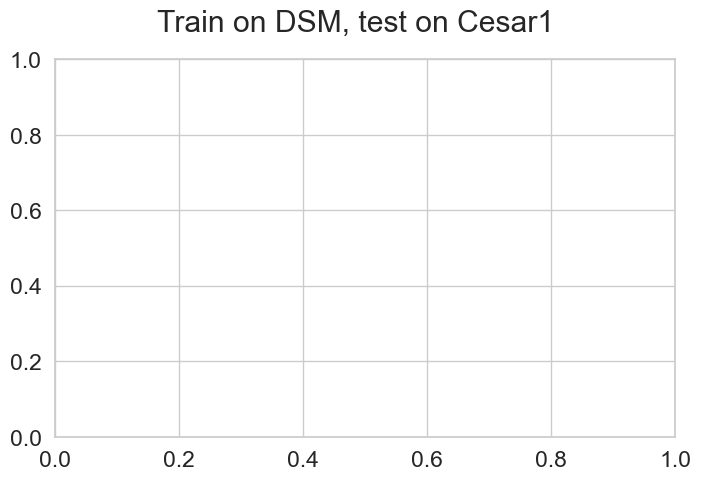

In [47]:
from source.postprocessing.plotter import dist_plot, bar_plot


dist_plot(results=GS_results_objects, models=names, plot_type='kdeplot', metric='f1', title='Train on DSM, test on Cesar1')
# dist_plot(estimators_score_distr, ['RFC', 'GBM', 'LR', 'KNN'], 'kdeplot', 'f1', (15, 8), 'Title', 'test')
# bar_plot(results=estimators_scores_means, models=names, metrics=['f1'], plot_size=(8, 12), Title='Train on our, test on Cesar1', filename='Our_Cesar1.png')

In [54]:
cv = Shuffler.PresplitedOverlapGroupCV(subset_size=0.63, n_repeats=n_repeats).split(X_scaled, y, groups=groups, train_groups=cesar_groups, test_groups=our_groups)
for train_id, test_id in cv:
    print(np.mean(train_id))

1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
1344.5
